In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
COLUMN = 'final_accuracy'

# Loading

In [3]:
raw_df = pd.read_csv('123_results.csv')
raw_test_df = pd.read_csv('test_results.csv')
masks = pd.read_csv('masks.csv')

In [4]:
# collect columns
columns = list(raw_df.columns)
columns = \
    columns[:10] + \
    columns[11:13] + \
    columns[15:] + \
    ['pre_' + i for i in columns[13:15]] + \
    ['post_' + i for i in columns[13:15]] + \
    ['pre_final_accuracy', 'post_final_accuracy', 't1_final_accuracy', 't2_final_accuracy', 'final_accuracy']

# collect rows
rows = list()
for i in range(len(raw_df)):
    if not i % 2:
        assert(raw_df.loc[i]['stage'] == 'post')
        post_row = list(raw_df.loc[i])
    else:
        assert(raw_df.loc[i]['stage'] == 'pre')
        pre_row = list(raw_df.loc[i])
        for j in range(10):
            assert(post_row[j] == pre_row[j])
        row = pre_row[:10]
        row += [np.array(post_row[11].split('_')),
                np.array(post_row[12].split('_')),
                post_row[15]]
        row += [float(i) for i in pre_row[13:15]]
        row += [float(i) for i in post_row[13:15]]
        t1_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['1', '2']))]['count'].sum()
        t2_size = masks[(masks['fold'] == str(pre_row[1])) & (masks['number'].isin(['3']))]['count'].sum()
        row += [float((pre_row[13] * t1_size + pre_row[14] * t2_size) / (t1_size + t2_size)),
                float((post_row[13] * t1_size + post_row[14] * t2_size) / (t1_size + t2_size)),
                float((pre_row[13] + post_row[13]) / 2),
                float((pre_row[14] + post_row[14]) / 2),
                float(((pre_row[13] + post_row[13]) * t1_size / 2 + (pre_row[14] + post_row[14]) * t2_size / 2) / (t1_size + t2_size))]
        rows.append(row)

# build new data frame
data = dict()
for i in range(len(columns)):
    data[columns[i]] = list()
    for j in range(len(rows)):
        data[columns[i]].append(rows[j][i])
df = pd.DataFrame(data=data)

In [5]:
df.head()

,seed,test_fold,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,...,predictions,pre_t1_final_accuracy,pre_t2_final_accuracy,post_t1_final_accuracy,post_t2_final_accuracy,pre_final_accuracy,post_final_accuracy,t1_final_accuracy,t2_final_accuracy,final_accuracy
0,0,0,100,adam,0.1,None,0.75,0.9,None,10,...,0:0:0:675:596:614:0:0:0_0:0:0:675:596:614:0:0:...,0.468922,0.0,0.468922,0.0,0.31618,0.31618,0.468922,0.0,0.31618
1,0,0,100,adam,0.1,None,0.75,0.9,None,20,...,0:0:0:675:596:614:0:0:0_0:0:0:675:596:614:0:0:...,0.468922,0.0,0.468922,0.0,0.31618,0.31618,0.468922,0.0,0.31618
2,0,0,100,adam,0.1,None,0.75,0.9,None,40,...,0:0:0:675:596:614:0:0:0_0:0:0:675:596:614:0:0:...,0.468922,0.0,0.468922,0.0,0.31618,0.31618,0.468922,0.0,0.31618
3,0,0,100,adam,0.1,None,0.75,0.9,None,5,...,0:0:0:675:596:614:0:0:0_0:0:0:675:596:614:0:0:...,0.468922,0.0,0.468922,0.0,0.31618,0.31618,0.468922,0.0,0.31618
4,0,0,100,adam,0.1,None,0.75,0.9,None,80,...,0:0:0:675:596:614:0:0:0_0:0:0:675:596:614:0:0:...,0.468922,0.0,0.468922,0.0,0.31618,0.31618,0.468922,0.0,0.31618


# Filtering

In [6]:
adf = df.drop(columns=['test_fold', 'predictions'])
grouped_columns, agg_columns = list(adf.columns[:9]), list(adf.columns[9:])
grouped = adf.groupby(grouped_columns)
data = {k: list() for k in grouped_columns}
for column in agg_columns:
    data[column + '_mean'] = list()
    data[column + '_std'] = list()
    data[column + '_min'] = list()
    data[column + '_max'] = list()
for k, v in grouped:
    i = 0
    for v2 in k:
        data[adf.columns[i]].append(v2)
        i += 1
    while i < len(adf.columns):
        data[adf.columns[i] + '_mean'].append(np.mean(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_std'].append(np.std(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_min'].append(np.min(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        data[adf.columns[i] + '_max'].append(np.max(np.array(list(v[adf.columns[i]]), dtype=float), axis=0))
        i += 1
adf = pd.DataFrame(data=data)

In [7]:
fdf = pd.DataFrame(columns=adf.columns)
for seed in np.unique(adf['seed'].values):
    for epoch in np.unique(adf['epochs'].values):
        adam_df = adf[(adf['optimizer'] == 'adam') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
        rms_df = adf[(adf['optimizer'] == 'rms') & (adf['seed'] == seed) & (adf['epochs'] == epoch)]
        sgd_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.0'])]
        sgdmom_df = adf[(adf['optimizer'] == 'sgd') & (adf['seed'] == seed) & (adf['epochs'] == epoch) & adf['momentum'].isin(['0.75', '0.9', '0.999'])]
        fdf = fdf.append(adam_df.loc[adam_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(rms_df.loc[rms_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(sgd_df.loc[sgd_df[COLUMN + '_mean'].idxmax()])
        fdf = fdf.append(sgdmom_df.loc[sgdmom_df[COLUMN + '_mean'].idxmax()])

In [8]:
fdf.head()

,seed,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,t1_accuracies_mean,...,t1_final_accuracy_min,t1_final_accuracy_max,t2_final_accuracy_mean,t2_final_accuracy_std,t2_final_accuracy_min,t2_final_accuracy_max,final_accuracy_mean,final_accuracy_std,final_accuracy_min,final_accuracy_max
40,0,100,adam,0.0001,None,0.999,0.99999,None,5,"[0.9822837999999999, 0.9879528000000001, 0.989...",...,0.892126,0.977542,0.453845,0.021855,0.411093,0.488581,0.788008,0.010492,0.760754,0.796287
190,0,100,rms,0.0001,None,None,None,0.99999,5,"[0.9942523, 0.9953546, 0.9951975000000001, 0.9...",...,0.497244,0.544847,0.500000,0.000000,0.500000,0.500000,0.511975,0.008913,0.498141,0.530255
560,0,50:50,sgd,0.0001,0.0,None,None,None,5,"[0.6817314, 0.7803129, 0.8407857, 0.8770057000...",...,0.695275,0.717323,0.493068,0.001513,0.490212,0.495106,0.637645,0.004679,0.630111,0.644639
275,0,100,sgd,0.0010,0.999,None,None,None,5,"[0.9855122, 0.9843314000000001, 0.988109899999...",...,0.732283,0.989378,0.000000,0.000000,0.000000,0.000000,0.630692,0.053101,0.493893,0.667109
401,0,50:50,adam,0.0010,None,0.999,0.999,None,10,"[0.9916537, 0.9923632, 0.9921260999999999, 0.9...",...,0.746063,0.995272,0.000000,0.000000,0.000000,0.000000,0.626119,0.063633,0.503186,0.671095


# Plotting

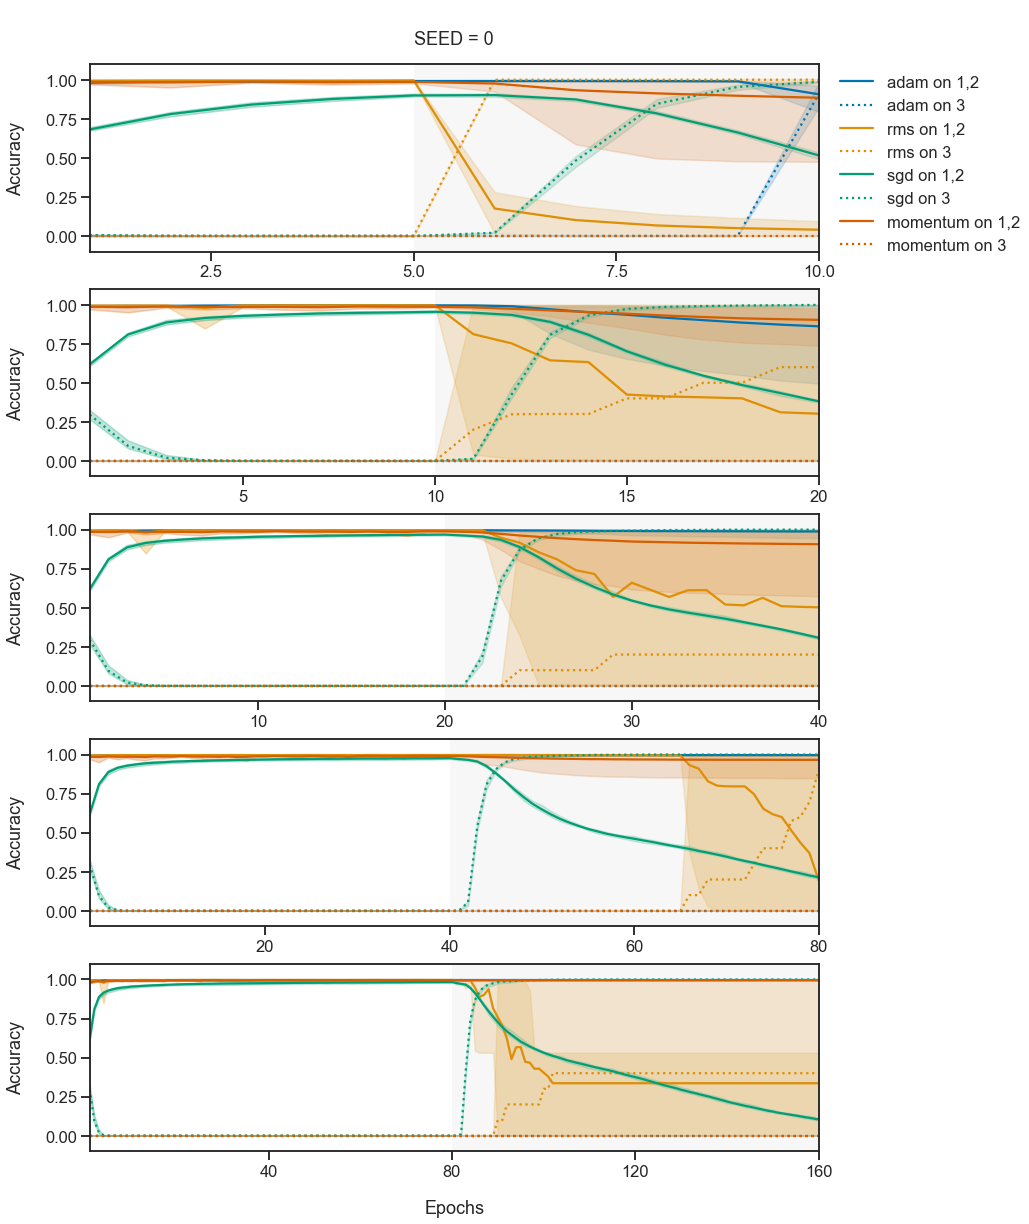

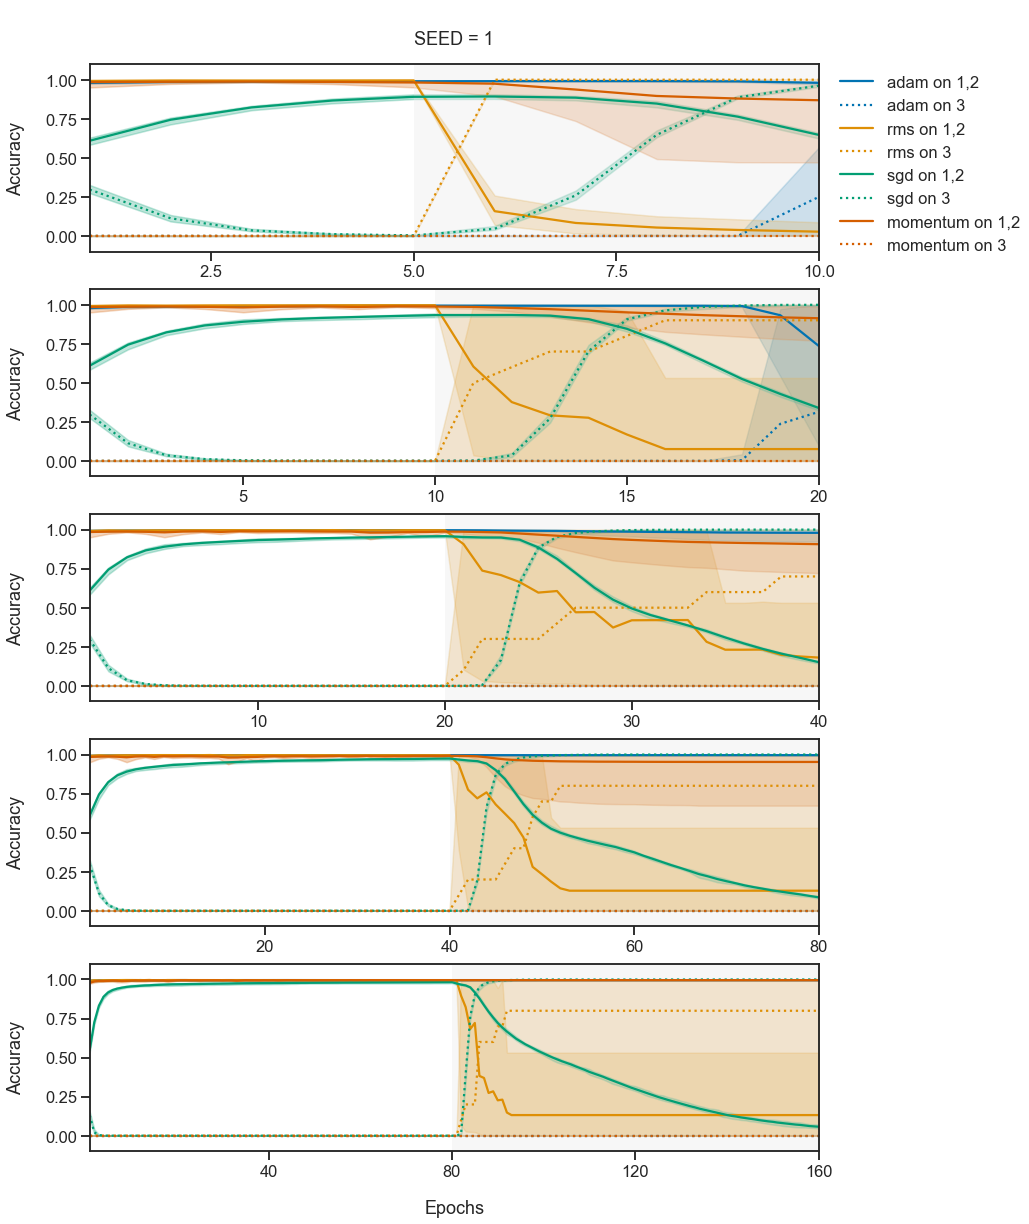

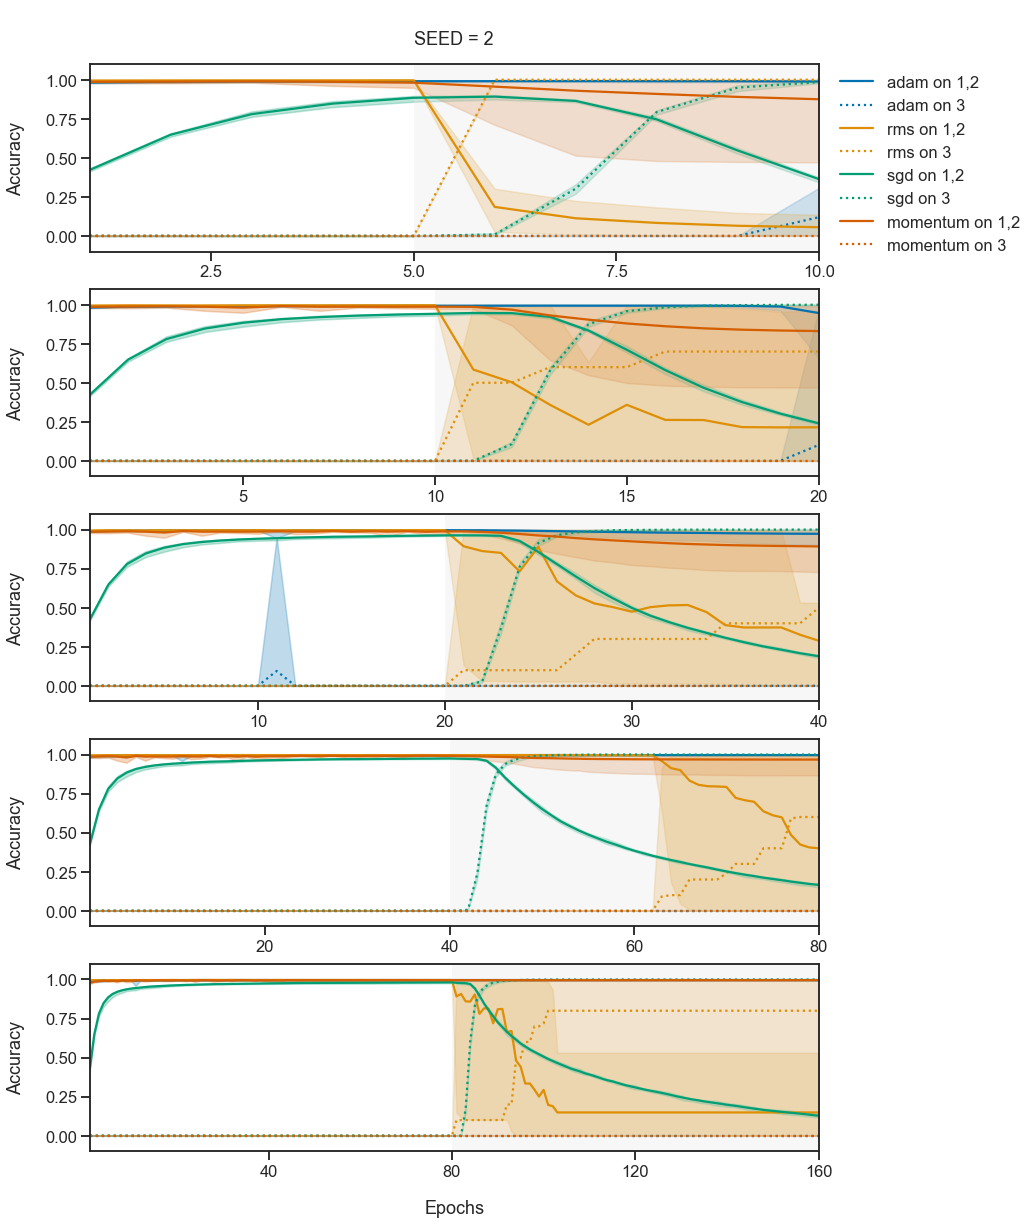

In [9]:
with PdfPages('results.pdf') as pdf:
    sns.set()
    sns.set_style('ticks')
    sns.set_context('talk')
    for seed in np.unique(fdf['seed'].values):
        sfdf = fdf[fdf['seed'] == seed]
        fig, axarr = plt.subplots(len(np.unique(sfdf['epochs'].values)), 1, figsize=(15, 20))
        palette = sns.color_palette('colorblind', 4)
        labels = list()
        axarr[0].set_title('SEED = {}'.format(seed), pad=20)
        for i, epoch in enumerate(np.unique(sfdf['epochs'].values)):
            axarr[i].set_ylabel('Accuracy', labelpad=20)
            if i == 4: axarr[i].set_xlabel('Epochs', labelpad=20)
            axarr[i].set_xticks(np.linspace(0, epoch * 2, 5, endpoint=True))
            axarr[i].set_xlim(1, epoch * 2)
            axarr[i].set_ylim(- 0.1, 1.1)
            labels.clear()
            for j, (_, row) in enumerate(sfdf[sfdf['epochs'] == epoch].iterrows()):
                if row['optimizer'] == 'sgd':
                    label = 'sgd' if row['momentum'] == '0.0' else 'momentum'
                else:
                    label = row['optimizer']
                labels.append(label + ' on 1,2')
                labels.append(label + ' on 3')
                x = np.arange(len(row['t1_accuracies_mean'])) + 1
                axarr[i].add_patch(Rectangle((epoch, - 0.1), epoch * 2, 1.2, color='0.925', alpha=0.1, linewidth=0))
                axarr[i].plot(x,
                              row['t1_accuracies_mean'],
                              linestyle='-',
                              color=palette[j])
                axarr[i].fill_between(x,
                              row['t1_accuracies_min'],
                              row['t1_accuracies_max'],
                              color=palette[j],
                              alpha=0.25)
                axarr[i].plot(x,
                              row['t2_accuracies_mean'],
                              linestyle=':',
                              color=palette[j])
                axarr[i].fill_between(x,
                              row['t2_accuracies_min'],
                              row['t2_accuracies_max'],
                              color=palette[j],
                              alpha=0.25)
        legend = fig.legend(axarr[0].get_lines(), labels, loc=(0.81, 0.7875), ncol=1, frameon=False)
        fig.subplots_adjust(right=0.8)
        pdf.savefig(fig, bbox_extra_artists=(legend,), bbox_inches='tight')

# Analysis

In [10]:
tdf = fdf[fdf['epochs'].isin([5]) & fdf['seed'].isin([0])]
tdf[grouped_columns + ['pre_final_accuracy_mean', 'post_final_accuracy_mean', 't1_final_accuracy_mean', 't2_final_accuracy_mean', 'final_accuracy_mean']]

,seed,architecture,optimizer,learning_rate,momentum,beta_1,beta_2,rho,epochs,pre_final_accuracy_mean,post_final_accuracy_mean,t1_final_accuracy_mean,t2_final_accuracy_mean,final_accuracy_mean
40,0,100,adam,0.0001,None,0.999,0.99999,None,5,0.668791,0.907225,0.949329,0.453845,0.788008
190,0,100,rms,0.0001,None,None,None,0.99999,5,0.671499,0.352451,0.517755,0.500000,0.511975
560,0,50:50,sgd,0.0001,0.0,None,None,None,5,0.606499,0.668791,0.707440,0.493068,0.637645
275,0,100,sgd,0.0010,0.999,None,None,None,5,0.664914,0.596469,0.935168,0.000000,0.630692
